# Entropy in Conway's Game of Life

**From Conway to LangGraph** — Week 2 Lab  
University of Bologna • Dept. of Physics

---

In this notebook we implement and explore several entropy measures for Conway's Game of Life:

1. **Density entropy** — the binary entropy of the alive/dead ratio
2. **2D block entropy** — Shannon entropy of $k \times k$ spatial patches
3. **Neighborhood pattern entropy** — entropy of Moore neighborhood configurations
4. **Temporal entropy** — per-cell activity maps over time
5. **Mutual information** — temporal correlations between cell states

We will observe how entropy evolves from random initial conditions toward equilibrium,
and investigate GoL's remarkable **anti-entropic** behavior.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from collections import Counter
from IPython.display import HTML
import matplotlib.animation as animation

# Plotting style
plt.rcParams.update({
    'figure.facecolor': '#1A1A1A',
    'axes.facecolor': '#242424',
    'axes.edgecolor': '#555555',
    'axes.labelcolor': '#F0F0F0',
    'text.color': '#F0F0F0',
    'xtick.color': '#A0A0A0',
    'ytick.color': '#A0A0A0',
    'grid.color': '#333333',
    'legend.facecolor': '#2D2D2D',
    'legend.edgecolor': '#555555',
    'font.size': 11,
})

# Course color palette
COLORS = {
    'accent': '#4A9ECC',
    'highlight': '#E8B931',
    'red': '#CC4444',
    'green': '#44AA66',
    'orange': '#D4853B',
}

print('Setup complete ✓')

Setup complete ✓


## Part 0: Game of Life Engine

We use a convolution-based update rule, fully vectorized with NumPy.
The kernel sums the 8 Moore neighbors (excluding the center cell).

In [ ]:
KERNEL = np.array([[1, 1, 1],
                   [1, 0, 1],
                   [1, 1, 1]])


def step(grid: np.ndarray) -> np.ndarray:
    """One GoL generation with periodic boundary conditions."""
    neighbors = convolve2d(grid, KERNEL, mode='same', boundary='wrap')
    return ((neighbors == 3) | (grid & (neighbors == 2))).astype(np.int8)

### How `convolve2d` counts neighbors

The key insight is that **counting alive neighbors is a discrete convolution**.

For each cell $(i,j)$, GoL needs the sum of its 8 Moore neighbors. Define the kernel:

$$K = \begin{pmatrix} 1 & 1 & 1 \\ 1 & 0 & 1 \\ 1 & 1 & 1 \end{pmatrix}$$

The zero in the center excludes the cell itself. Then the neighbor count at every position is:

$$N(i,j) = \sum_{m,n} \text{grid}(i+m,\, j+n) \cdot K(m,n) = (\text{grid} * K)(i,j)$$

This is exactly a 2D discrete convolution — the same operation used in signal processing, image filtering, and (flipped) in convolutional neural networks.

**Parameters:**
- `mode='same'` → output has the same shape as the input grid (no shrinkage)
- `boundary='wrap'` → periodic boundary conditions (the grid lives on a **torus**: left edge is glued to the right, top to the bottom)

**Why this matters:**
`scipy.signal.convolve2d` runs the convolution in optimized C/Fortran under the hood, replacing what would otherwise be a double Python loop over all cells — turning an $O(N^2)$ slow loop into a single vectorized call. For a 100×100 grid this is typically **100–1000× faster** than the naive implementation.

After this line, `neighbors[i,j]` contains the integer count (0–8) of alive neighbors for every cell simultaneously, and the GoL rule reduces to a simple boolean expression:
```python
new_grid = (neighbors == 3) | (grid & (neighbors == 2))
```

*Birth* (dead cell with exactly 3 neighbors) **or** *survival* (alive cell with 2 or 3 neighbors).

In [ ]:
def evolve(grid: np.ndarray, steps: int) -> np.ndarray:
    """Return full spacetime history as a (steps+1, rows, cols) array."""
    history = np.zeros((steps + 1, *grid.shape), dtype=np.int8)
    history[0] = grid
    for t in range(steps):
        history[t + 1] = step(history[t])
    return history


def random_soup(rows: int, cols: int, density: float = 0.5) -> np.ndarray:
    """Generate a random initial configuration."""
    return (np.random.random((rows, cols)) < density).astype(np.int8)




### Generating a random initial configuration

This one-liner builds a random binary grid in three steps:

**Step 1 — `np.random.random((rows, cols))`**

Generates a `rows × cols` matrix of i.i.d. uniform random numbers in $[0, 1)$:

$$U_{ij} \sim \text{Uniform}(0,1) \qquad \forall\, (i,j)$$

**Step 2 — `< density`**

A boolean comparison broadcast over the entire array. Each entry becomes `True` with probability equal to `density`:

$$P(U_{ij} < \rho_0) = \rho_0$$

So this is equivalent to drawing each cell independently from a **Bernoulli distribution** $\text{Bern}(\rho_0)$. With `density=0.5` you get a fair coin flip per cell (maximum entropy initial condition); with `density=0.1` you get a sparse soup.

**Step 3 — `.astype(np.int8)`**

Casts `True/False` → `1/0` as 8-bit integers (1 byte per cell instead of 8 for a standard `int64`). For a 200×200 grid this means 40 KB instead of 320 KB — a small saving, but it adds up when you store hundreds of time steps in a history array.

**The physics perspective:** this construction gives us a lattice of i.i.d. Bernoulli variables — the discrete analogue of an **ideal gas** at density $\rho_0$. There are no spatial correlations at $t=0$, so the initial block entropy is maximal ($s_k \approx 1$ bit/cell for all $k$). Everything interesting that happens next — the entropy drop, the emergence of structure — is entirely produced by the GoL dynamics.

In [ ]:
# Quick test
grid = random_soup(50, 50)
history = evolve(grid, 10)
print(f'Grid shape: {grid.shape}')
print(f'History shape: {history.shape}')
print(f'Population at t=0: {history[0].sum()}, t=10: {history[10].sum()}')

Grid shape: (50, 50)
History shape: (11, 50, 50)
Population at t=0: 1283, t=10: 486


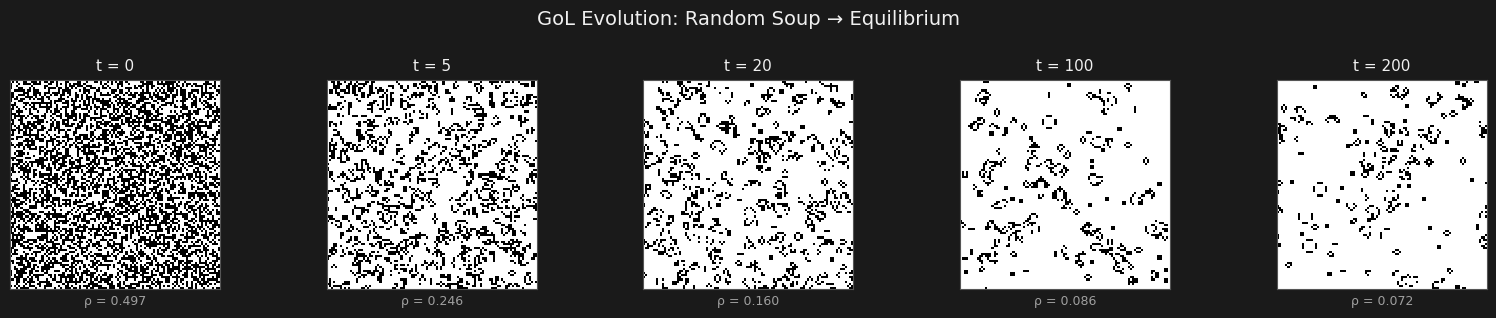

In [ ]:
# Visualize a short evolution
grid = random_soup(100, 100, density=0.5)
history = evolve(grid, 200)

fig, axes = plt.subplots(1, 5, figsize=(16, 3))
times = [0, 5, 20, 100, 200]
for ax, t in zip(axes, times):
    ax.imshow(history[t], cmap='gray_r', interpolation='nearest')
    ax.set_title(f't = {t}', fontsize=11)
    ax.set_xticks([]); ax.set_yticks([])
    pop = history[t].sum()
    rho = history[t].mean()
    ax.set_xlabel(f'ρ = {rho:.3f}', fontsize=9, color='#A0A0A0')

fig.suptitle('GoL Evolution: Random Soup → Equilibrium', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---

## Part 1: Density Entropy

The simplest information-theoretic measure: the **binary entropy** of the alive fraction $\rho$.

$$H_{\text{density}}(t) = -\rho(t) \log_2 \rho(t) - (1 - \rho(t)) \log_2 (1 - \rho(t))$$

This is the entropy of a single Bernoulli random variable with parameter $\rho$.

- $H = 0$ when $\rho = 0$ or $\rho = 1$ (all dead or all alive)
- $H = 1$ bit when $\rho = 0.5$ (maximum uncertainty)

**Limitation:** density entropy ignores spatial structure entirely.

In [ ]:
def density_entropy(grid: np.ndarray) -> float:
    """Binary entropy of the alive fraction."""
    rho = grid.mean()
    if rho == 0 or rho == 1:
        return 0.0
    return -rho * np.log2(rho) - (1 - rho) * np.log2(1 - rho)


def entropy_trajectory(history: np.ndarray) -> np.ndarray:
    """Compute H_density(t) for a full spacetime history."""
    return np.array([density_entropy(h) for h in history])


def density_trajectory(history: np.ndarray) -> np.ndarray:
    """Compute ρ(t) for a full spacetime history."""
    return np.array([h.mean() for h in history])

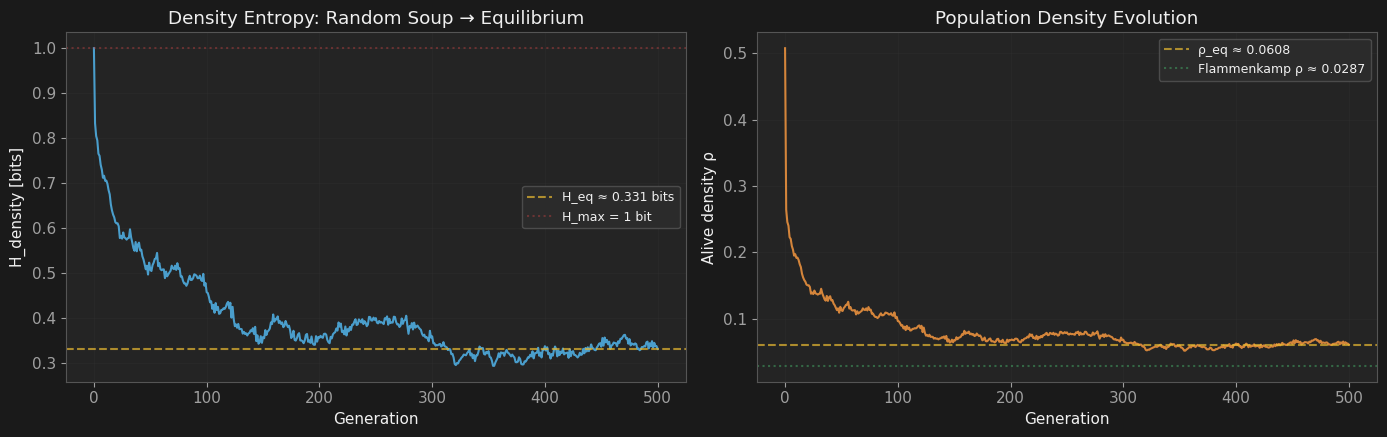

Initial:     H = 0.9998 bits,  ρ = 0.5076
Final:       H = 0.3306 bits,  ρ = 0.0608
Entropy drop: ΔH = 0.6692 bits


In [ ]:
# Run a 100x100 random soup for 500 steps
np.random.seed(42)
grid = random_soup(100, 100, density=0.5)
history = evolve(grid, 500)

H = entropy_trajectory(history)
rho = density_trajectory(history)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))

# Density entropy
ax1.plot(H, color=COLORS['accent'], linewidth=1.5)
ax1.axhline(y=H[-1], color=COLORS['highlight'], ls='--', alpha=0.7,
            label=f'H_eq ≈ {H[-1]:.3f} bits')
ax1.axhline(y=1.0, color=COLORS['red'], ls=':', alpha=0.4, label='H_max = 1 bit')
ax1.set_xlabel('Generation')
ax1.set_ylabel('H_density [bits]')
ax1.set_title('Density Entropy: Random Soup → Equilibrium')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Density
ax2.plot(rho, color=COLORS['orange'], linewidth=1.5)
ax2.axhline(y=rho[-1], color=COLORS['highlight'], ls='--', alpha=0.7,
            label=f'ρ_eq ≈ {rho[-1]:.4f}')
ax2.axhline(y=0.0287, color=COLORS['green'], ls=':', alpha=0.5,
            label='Flammenkamp ρ ≈ 0.0287')
ax2.set_xlabel('Generation')
ax2.set_ylabel('Alive density ρ')
ax2.set_title('Population Density Evolution')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Initial:     H = {H[0]:.4f} bits,  ρ = {rho[0]:.4f}')
print(f'Final:       H = {H[-1]:.4f} bits,  ρ = {rho[-1]:.4f}')
print(f'Entropy drop: ΔH = {H[0] - H[-1]:.4f} bits')

### Observation

The density entropy drops sharply from its maximum value ($H = 1$ bit at $\rho_0 = 0.5$)
in the first ~50 generations, then slowly converges. The equilibrium density approaches
**Flammenkamp's constant** $\rho \approx 0.0287$, a characteristic of GoL's asymptotic behavior
from random soups.

This is **anti-entropic** behavior: order spontaneously emerges from disorder.

---

## Part 2: 2D Block Entropy

To capture **spatial correlations**, we compute the Shannon entropy of $k \times k$ block patterns.

For a grid, extract all overlapping $k \times k$ sub-blocks. Each block is a binary pattern
$b \in \{0,1\}^{k^2}$, giving up to $2^{k^2}$ possible configurations.

$$H_k = -\sum_{b} p(b) \log_2 p(b)$$

**Entropy per cell:** $s_k = H_k / k^2$

**Maximum:** $H_k = k^2$ bits (all $2^{k^2}$ patterns equally likely, i.e. random)

This is the 2D analogue of the block entropy used for 1D elementary CA.

### Computing 2D block entropy: the vectorized pipeline

This code extracts all $k \times k$ sub-patches from the grid, encodes each as an integer, and counts their frequencies — all without a single Python loop. Let's walk through it.

---

**Step 1 — Sliding window extraction**
```python
blocks = np.lib.stride_tricks.sliding_window_view(grid, (k, k))
```

This creates a **view** (not a copy!) of every overlapping $k \times k$ block in the grid. For a $100 \times 100$ grid with $k=2$:

$$\text{blocks.shape} = (99, 99, 2, 2)$$

The entry `blocks[i, j]` is the $2 \times 2$ sub-array starting at position $(i,j)$. The magic of `stride_tricks` is that this costs **zero memory** — it just tells NumPy to re-interpret the same underlying data with different index strides. This replaces what would be a slow double loop:
```python
# This is what we're avoiding:
for i in range(rows - k + 1):
    for j in range(cols - k + 1):
        block = grid[i:i+k, j:j+k]  # 😴
```

---

**Step 2 — Flatten each block into a row vector**
```python
flat = blocks.reshape(-1, k * k)
```

The 4D array becomes a 2D matrix where each row is one flattened block. For $k=2$: shape $(99 \times 99, \; 4) = (9801, 4)$. Each row is a binary vector like `[0, 1, 1, 0]`.

---

**Step 3 — Binary-to-integer encoding**
```python
powers = 2 ** np.arange(k * k)   # [1, 2, 4, 8] for k=2
keys = flat @ powers              # matrix-vector product
```

This is the crucial trick. Each $k^2$-bit binary pattern is mapped to a unique integer via positional encoding:

$$\text{key} = b_0 \cdot 2^0 + b_1 \cdot 2^1 + \cdots + b_{k^2-1} \cdot 2^{k^2-1}$$

For $k=2$ the 16 possible $2\times 2$ patterns map to integers $0, 1, \ldots, 15$. For $k=3$, to $0, \ldots, 511$. The `@` operator performs this dot product for all blocks simultaneously in one vectorized call.

**Why not just hash tuples?** Because `np.bincount` (next step) needs integer keys, and the dot product is orders of magnitude faster than Python-level hashing of tuples.

---

**Step 4 — Frequency counting**
```python
counts = np.bincount(keys, minlength=2 ** (k * k))
```

`np.bincount` is NumPy's optimized histogram for non-negative integers. It returns an array where `counts[j]` = number of times integer $j$ appears in `keys`. The `minlength` argument ensures the output always has $2^{k^2}$ bins, even for patterns that never occur (they get count 0).

---

**Step 5 — Probabilities and log-safety**
```python
probs = counts / counts.sum()
probs = probs[probs > 0]
```

Normalize to a probability distribution, then discard zeros. This is essential because $0 \cdot \log_2(0)$ is undefined, but by convention (and by L'Hôpital) we take $\lim_{p \to 0^+} p \log p = 0$. Filtering them out achieves the same effect and avoids `nan` in the entropy sum.

---

**Complexity summary:**

| Approach | Time | Memory |
|:--|:--|:--|
| Naive double loop + Counter | $O(N \cdot k^2)$, slow Python overhead | $O(N)$ |
| This pipeline | $O(N \cdot k^2)$, all in C/BLAS | $O(N \cdot k^2)$ for `flat` |

where $N = (\text{rows} - k + 1)(\text{cols} - k + 1)$ is the number of blocks. The practical speedup is typically **50–200×** for $k \leq 4$ on grids of size $100 \times 100$ or larger.

**Caveat:** for large $k$, the number of possible patterns $2^{k^2}$ explodes (e.g. $2^{25} \approx 33$M for $k=5$), so you need a large grid to get meaningful frequency estimates. A rule of thumb: grid area should be $\gg 2^{k^2}$ for good statistics.

In [ ]:
def block_entropy_2d(grid: np.ndarray, k: int = 2) -> float:
    """
    Shannon entropy of k×k block patterns.

    Uses stride tricks for vectorized extraction (no Python loops
    over cells) and binary-to-integer encoding for fast counting.

    Parameters
    ----------
    grid : 2D binary array
    k : block size (k×k patches)

    Returns
    -------
    H_k : Shannon entropy in bits
    """
    # Extract all k×k blocks via sliding window
    blocks = np.lib.stride_tricks.sliding_window_view(grid, (k, k))
    # blocks shape: (rows-k+1, cols-k+1, k, k)
    #https://numpy.org/doc/stable/reference/generated/numpy.lib.stride_tricks.sliding_window_view.html#

    # Flatten each block and encode as integer
    flat = blocks.reshape(-1, k * k)
    powers = 2 ** np.arange(k * k)
    keys = flat @ powers  # binary → integer key

    # Count frequencies
    counts = np.bincount(keys, minlength=2 ** (k * k))
    probs = counts / counts.sum()
    probs = probs[probs > 0]  # avoid log(0)

    return -np.sum(probs * np.log2(probs))

In [ ]:
# Compare block entropies: random vs. settled
np.random.seed(42)
random_grid = random_soup(200, 200, density=0.5)
settled_grid = evolve(random_grid.copy(), 500)[-1]

print('Block entropy comparison: random soup vs. settled configuration')
print(f'{"k":>3}  {"H_random":>10}  {"H_settled":>10}  {"H_max":>8}  {"ratio":>8}')
print('-' * 48)
for k in [1, 2, 3, 4, 5]:
    H_rand = block_entropy_2d(random_grid, k)
    H_sett = block_entropy_2d(settled_grid, k)
    H_max = k * k  # bits
    ratio = H_sett / H_rand if H_rand > 0 else 0
    print(f'{k:>3}  {H_rand:>10.3f}  {H_sett:>10.3f}  {H_max:>8.1f}  {ratio:>8.3f}')

Block entropy comparison: random soup vs. settled configuration
  k    H_random   H_settled     H_max     ratio
------------------------------------------------
  1       1.000       0.292       1.0     0.292
  2       4.000       0.998       4.0     0.249
  3       8.990       2.026       9.0     0.225
  4      14.710       3.165      16.0     0.215
  5      15.228       4.268      25.0     0.280


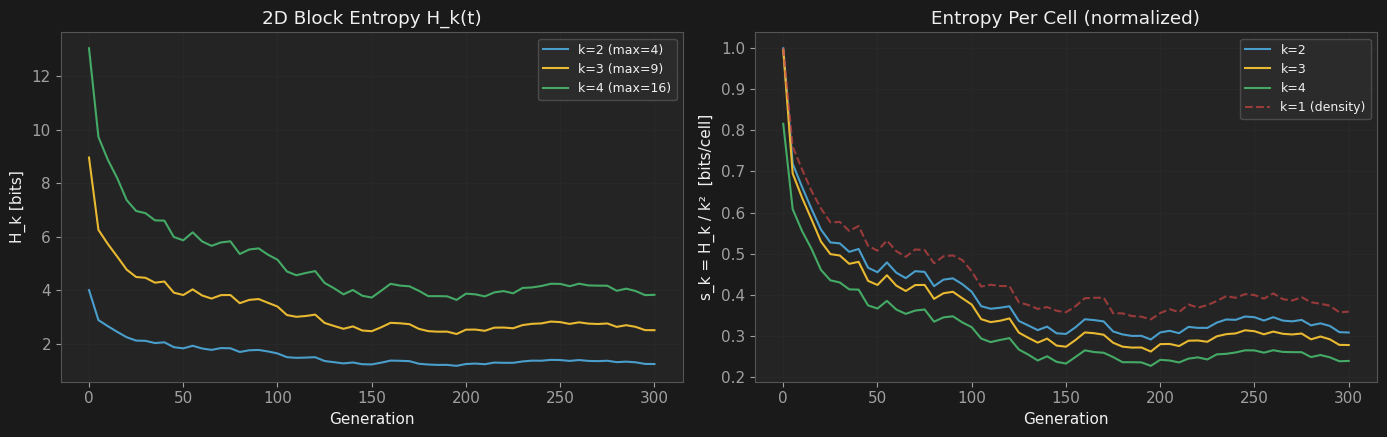

In [ ]:
# Block entropy trajectory over time (k=2)
np.random.seed(42)
grid = random_soup(100, 100)
history = evolve(grid, 300)

# Compute for several block sizes (subsample time for speed)
sample_times = np.arange(0, 301, 5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))

for k, color in zip([2, 3, 4], [COLORS['accent'], COLORS['highlight'], COLORS['green']]):
    H_block = [block_entropy_2d(history[t], k) for t in sample_times]
    ax1.plot(sample_times, H_block, color=color, linewidth=1.5,
             label=f'k={k} (max={k*k})')

ax1.set_xlabel('Generation')
ax1.set_ylabel('H_k [bits]')
ax1.set_title('2D Block Entropy H_k(t)')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Entropy per cell: s_k = H_k / k²
for k, color in zip([2, 3, 4], [COLORS['accent'], COLORS['highlight'], COLORS['green']]):
    s_k = [block_entropy_2d(history[t], k) / (k * k) for t in sample_times]
    ax2.plot(sample_times, s_k, color=color, linewidth=1.5, label=f'k={k}')

# Also plot density entropy for comparison
H_dens = [density_entropy(history[t]) for t in sample_times]
ax2.plot(sample_times, H_dens, color=COLORS['red'], linewidth=1.5,
         ls='--', label='k=1 (density)', alpha=0.7)

ax2.set_xlabel('Generation')
ax2.set_ylabel('s_k = H_k / k²  [bits/cell]')
ax2.set_title('Entropy Per Cell (normalized)')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Observation

As the block size $k$ increases, we capture progressively more spatial structure.
The entropy per cell $s_k = H_k / k^2$ **decreases** with $k$ for the settled configuration,
reflecting the fact that neighboring cells are correlated (not independent).

For a truly random grid, $s_k \approx 1$ for all $k$ (cells are independent).
The gap between the random and settled curves quantifies the **spatial order**
that has emerged through self-organization.

---

## Part 3: Neighborhood Pattern Entropy

The Game of Life rule depends on the **Moore neighborhood**: the cell itself plus its 8 neighbors.
This gives a 9-bit configuration with $2^9 = 512$ possible states.

Since GoL is **totalistic** (only the neighbor *count* matters, not the arrangement),
we can also compute a coarser entropy based on the 10 possible sum values (0–9 alive cells).

Two modes:
- `'sum'`: entropy of the 10 sum classes → max $\log_2(10) \approx 3.32$ bits
- `'full'`: entropy of all 512 patterns → max 9 bits

In [ ]:
def neighborhood_entropy(grid: np.ndarray, mode: str = 'sum') -> float:
    """
    Entropy of Moore neighborhood configurations.

    Parameters
    ----------
    grid : 2D binary array
    mode : 'sum' (10 classes, totalistic) or 'full' (512 classes)

    Returns
    -------
    H : Shannon entropy in bits
    """
    kernel_full = np.ones((3, 3), dtype=int)

    if mode == 'sum':
        # Count alive cells in 3x3 neighborhood (including center)
        total = convolve2d(grid, kernel_full, mode='same', boundary='wrap')
        counts = np.bincount(total.ravel(), minlength=10)
    else:
        # Encode full 3x3 neighborhood as 9-bit integer
        padded = np.pad(grid, 1, mode='wrap')
        patches = np.lib.stride_tricks.sliding_window_view(padded, (3, 3))
        powers = 2 ** np.arange(9).reshape(3, 3)
        keys = (patches * powers).sum(axis=(-2, -1))
        counts = np.bincount(keys.ravel(), minlength=512)

    probs = counts / counts.sum()
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

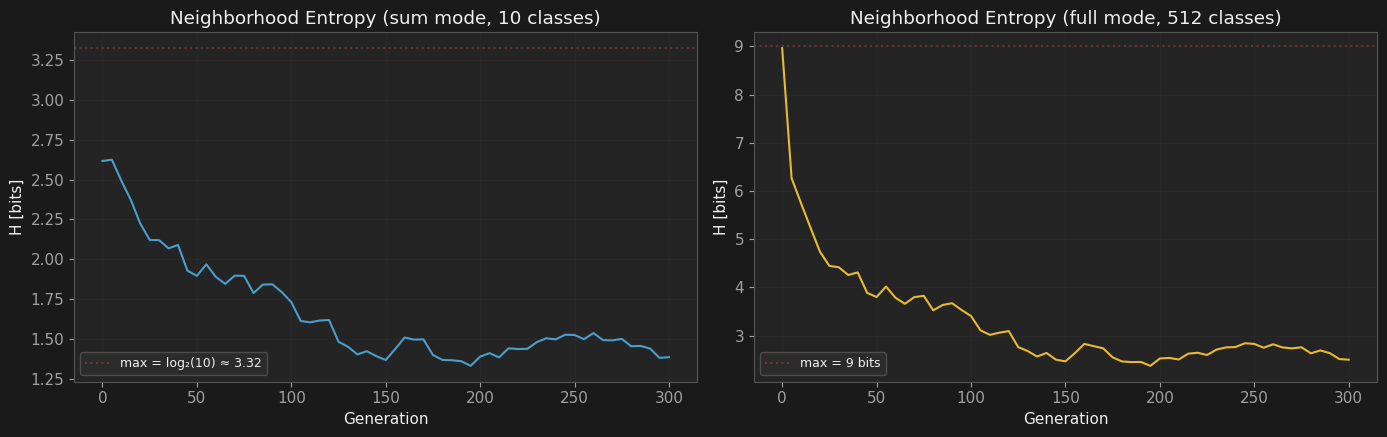

Initial: H_sum = 2.616, H_full = 8.964
Final:   H_sum = 1.388, H_full = 2.499


In [ ]:
# Neighborhood entropy trajectory
np.random.seed(42)
grid = random_soup(100, 100)
history = evolve(grid, 300)

sample_times = np.arange(0, 301, 5)

H_sum  = [neighborhood_entropy(history[t], mode='sum')  for t in sample_times]
H_full = [neighborhood_entropy(history[t], mode='full') for t in sample_times]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))

ax1.plot(sample_times, H_sum, color=COLORS['accent'], linewidth=1.5)
ax1.axhline(y=np.log2(10), color=COLORS['red'], ls=':', alpha=0.4,
            label=f'max = log₂(10) ≈ {np.log2(10):.2f}')
ax1.set_xlabel('Generation')
ax1.set_ylabel('H [bits]')
ax1.set_title('Neighborhood Entropy (sum mode, 10 classes)')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

ax2.plot(sample_times, H_full, color=COLORS['highlight'], linewidth=1.5)
ax2.axhline(y=9.0, color=COLORS['red'], ls=':', alpha=0.4,
            label='max = 9 bits')
ax2.set_xlabel('Generation')
ax2.set_ylabel('H [bits]')
ax2.set_title('Neighborhood Entropy (full mode, 512 classes)')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Initial: H_sum = {H_sum[0]:.3f}, H_full = {H_full[0]:.3f}')
print(f'Final:   H_sum = {H_sum[-1]:.3f}, H_full = {H_full[-1]:.3f}')

### Observation

The full neighborhood entropy (512 classes) drops more dramatically than the sum-based
version, because it captures the **spatial arrangement** of neighbors, not just the count.
In the settled configuration, most neighborhoods are either all-dead (the vast majority)
or belong to a small set of still life / oscillator patterns.

---

## Part 4: Temporal Entropy

Instead of looking at a single snapshot, we ask: **how unpredictable is each cell over time?**

For cell $(i,j)$ over $T$ time steps:

$$f_{ij} = \frac{1}{T} \sum_t c_{ij}(t) \quad \text{(fraction of time alive)}$$

$$H_{ij} = -f_{ij} \log_2 f_{ij} - (1 - f_{ij}) \log_2 (1 - f_{ij})$$

This produces a **spatial map** of temporal activity:
- $H_{ij} = 0$: cell is always dead or always alive (still life, dead zone)
- $H_{ij} = 1$: cell flips with equal probability (maximum unpredictability)
- $H_{ij} \approx h(1/p)$: cell is part of a period-$p$ oscillator

In [ ]:
def temporal_entropy_map(history: np.ndarray) -> np.ndarray:
    """
    Compute per-cell temporal entropy over a history.

    Parameters
    ----------
    history : (T, rows, cols) spacetime array

    Returns
    -------
    H_map : (rows, cols) array of temporal entropy values
    """
    # Fraction of time each cell is alive
    f = history.mean(axis=0).astype(np.float64)

    # Binary entropy, handling edge cases
    H = np.zeros_like(f)
    mask = (f > 0) & (f < 1)
    H[mask] = (-f[mask] * np.log2(f[mask])
               - (1 - f[mask]) * np.log2(1 - f[mask]))
    return H

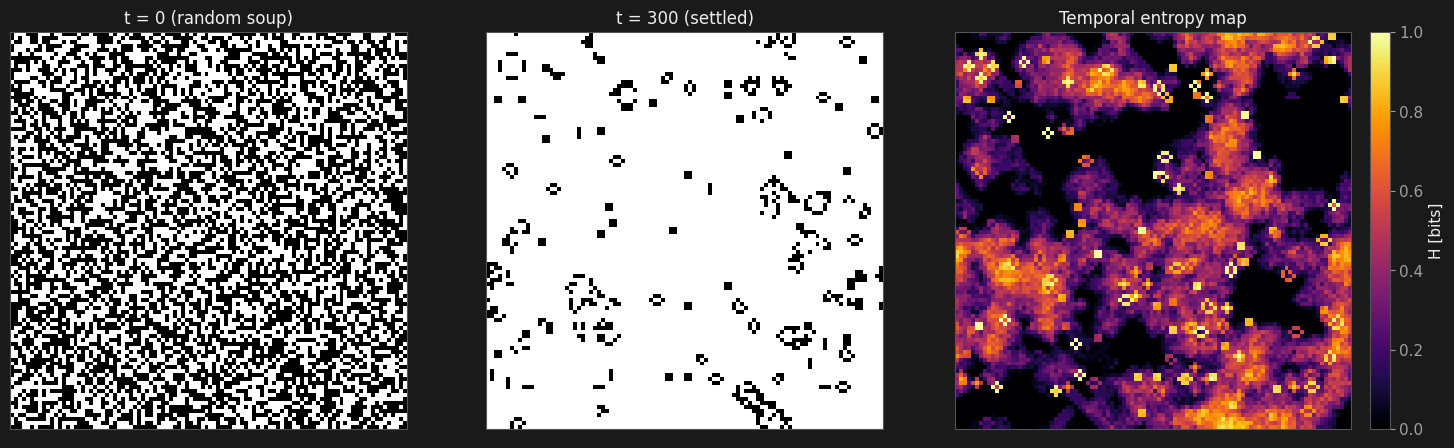

Temporal entropy statistics (last 200 steps):
  Mean H:       0.2776 bits
  Active cells:  7420 / 10000 (74.2%)
  Mean H (active): 0.3741 bits
  Max H:           1.0000 bits


In [ ]:
# Random soup: temporal entropy map
np.random.seed(42)
grid = random_soup(100, 100)
history = evolve(grid, 300)

# Use last 200 steps (after transient has settled)
H_map = temporal_entropy_map(history[100:])

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

axes[0].imshow(history[0], cmap='gray_r', interpolation='nearest')
axes[0].set_title('t = 0 (random soup)', fontsize=12)

axes[1].imshow(history[-1], cmap='gray_r', interpolation='nearest')
axes[1].set_title('t = 300 (settled)', fontsize=12)

im = axes[2].imshow(H_map, cmap='inferno', interpolation='nearest',
                     vmin=0, vmax=1)
axes[2].set_title('Temporal entropy map', fontsize=12)
plt.colorbar(im, ax=axes[2], label='H [bits]', fraction=0.046, pad=0.04)

for ax in axes:
    ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()

# Statistics
nonzero = H_map[H_map > 0]
print(f'Temporal entropy statistics (last 200 steps):')
print(f'  Mean H:       {H_map.mean():.4f} bits')
print(f'  Active cells:  {len(nonzero)} / {H_map.size} ({100*len(nonzero)/H_map.size:.1f}%)')
if len(nonzero) > 0:
    print(f'  Mean H (active): {nonzero.mean():.4f} bits')
    print(f'  Max H:           {nonzero.max():.4f} bits')

### Temporal Entropy of Known Patterns

Let's compare the temporal entropy signatures of specific GoL patterns.

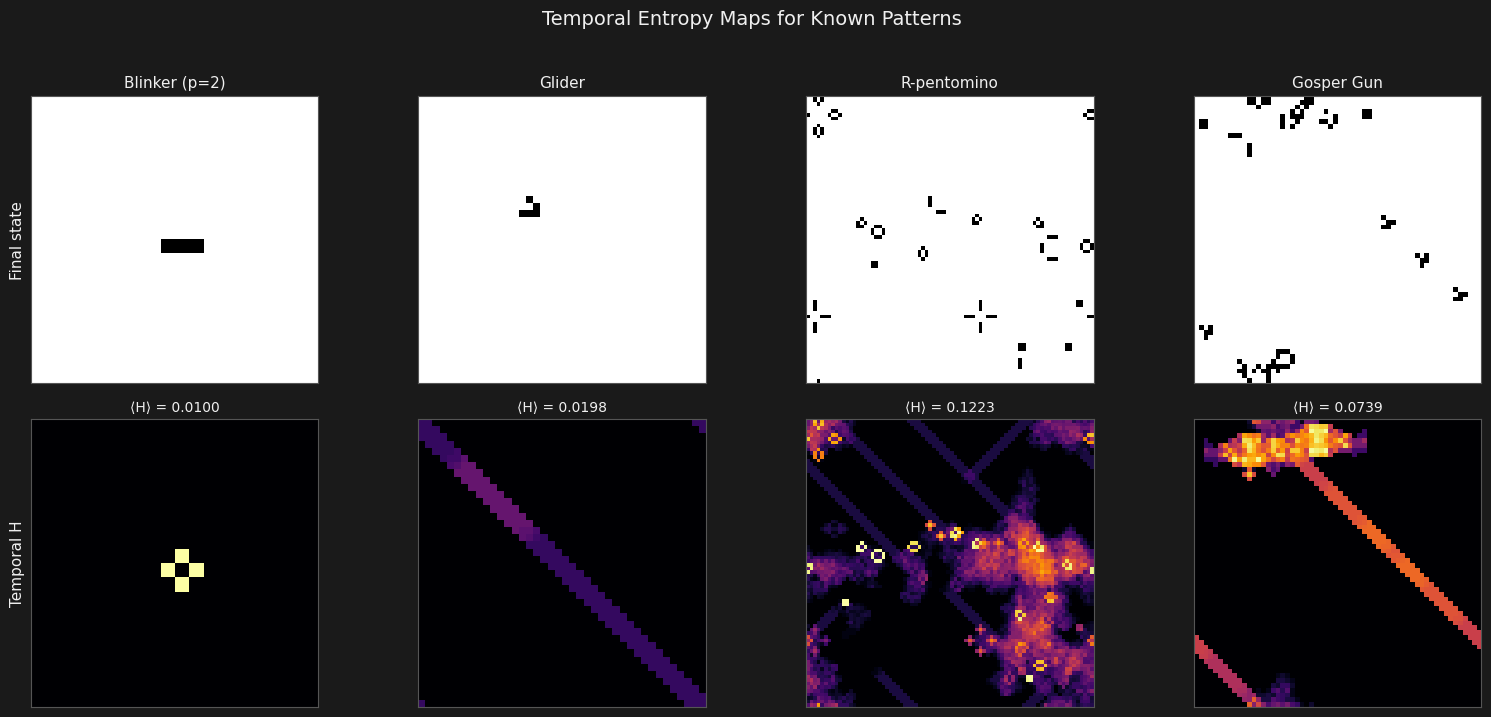

In [ ]:
# Pattern library
def make_pattern_grid(pattern: np.ndarray, size: int = 40,
                      offset: tuple = None) -> np.ndarray:
    """Place a pattern on a grid."""
    grid = np.zeros((size, size), dtype=np.int8)
    if offset is None:
        offset = (size // 2 - pattern.shape[0] // 2,
                  size // 2 - pattern.shape[1] // 2)
    r, c = offset
    grid[r:r + pattern.shape[0], c:c + pattern.shape[1]] = pattern
    return grid

# Blinker (period 2)
blinker = np.array([[1, 1, 1]])

# Pulsar (period 3)
pulsar = np.zeros((13, 13), dtype=np.int8)
for dr in [-1, 1]:
    for dc in [-1, 1]:
        r0, c0 = 6 + dr, 6 + dc
        pulsar[r0 + dr*1, c0 + dc*2] = 1
        pulsar[r0 + dr*1, c0 + dc*3] = 1
        pulsar[r0 + dr*1, c0 + dc*4] = 1
        pulsar[r0 + dr*2, c0 + dc*1] = 1
        pulsar[r0 + dr*3, c0 + dc*1] = 1
        pulsar[r0 + dr*4, c0 + dc*1] = 1
        pulsar[r0 + dr*2, c0 + dc*6-dc*1] = 1
        pulsar[r0 + dr*3, c0 + dc*6-dc*1] = 1
        pulsar[r0 + dr*4, c0 + dc*6-dc*1] = 1
        pulsar[r0 + dr*6-dr*1, c0 + dc*2] = 1
        pulsar[r0 + dr*6-dr*1, c0 + dc*3] = 1
        pulsar[r0 + dr*6-dr*1, c0 + dc*4] = 1

# Glider
glider = np.array([[0, 1, 0],
                   [0, 0, 1],
                   [1, 1, 1]])

# R-pentomino (methuselah)
r_pentomino = np.array([[0, 1, 1],
                        [1, 1, 0],
                        [0, 1, 0]])

# Gosper Glider Gun
def gosper_gun_grid(size=60):
    """Create a grid with Gosper Glider Gun."""
    grid = np.zeros((size, size), dtype=np.int8)
    gun = [
        (5, 1), (5, 2), (6, 1), (6, 2),
        (3, 13), (3, 14), (4, 12), (4, 16), (5, 11), (5, 17),
        (6, 11), (6, 15), (6, 17), (6, 18), (7, 11), (7, 17),
        (8, 12), (8, 16), (9, 13), (9, 14),
        (1, 25), (2, 23), (2, 25), (3, 21), (3, 22),
        (4, 21), (4, 22), (5, 21), (5, 22),
        (6, 23), (6, 25), (7, 25),
        (3, 35), (3, 36), (4, 35), (4, 36),
    ]
    for r, c in gun:
        if 0 <= r < size and 0 <= c < size:
            grid[r, c] = 1
    return grid

# Set up patterns
patterns = {
    'Blinker (p=2)': make_pattern_grid(blinker, 20),
    'Glider': make_pattern_grid(glider, 40),
    'R-pentomino': make_pattern_grid(r_pentomino, 80),
    'Gosper Gun': gosper_gun_grid(60),
}

fig, axes = plt.subplots(2, 4, figsize=(16, 7))

for i, (name, grid) in enumerate(patterns.items()):
    steps = 300 if 'pentomino' not in name else 500
    hist = evolve(grid, steps)
    H_map = temporal_entropy_map(hist[steps//3:])

    axes[0, i].imshow(hist[-1], cmap='gray_r', interpolation='nearest')
    axes[0, i].set_title(name, fontsize=11)
    axes[0, i].set_xticks([]); axes[0, i].set_yticks([])

    im = axes[1, i].imshow(H_map, cmap='inferno', interpolation='nearest',
                           vmin=0, vmax=1)
    axes[1, i].set_title(f'⟨H⟩ = {H_map.mean():.4f}', fontsize=10)
    axes[1, i].set_xticks([]); axes[1, i].set_yticks([])

axes[0, 0].set_ylabel('Final state', fontsize=11)
axes[1, 0].set_ylabel('Temporal H', fontsize=11)

fig.suptitle('Temporal Entropy Maps for Known Patterns', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---

## Part 5: Mutual Information

How predictable is a cell's future state from its present state?

$$I(c_{ij}(t) \,;\, c_{ij}(t+\tau)) = H(c_{ij}(t)) + H(c_{ij}(t+\tau)) - H(c_{ij}(t), c_{ij}(t+\tau))$$

- **High MI**: cell state persists (still lifes, stable regions)
- **Low MI**: cell state is uncorrelated with its future (chaotic dynamics)
- **Moderate MI**: periodic behavior (oscillators, predictable but changing)

In [ ]:
def mutual_information_temporal(history: np.ndarray, tau: int = 1):
    """
    Average mutual information between cell state at t and t+tau.

    Parameters
    ----------
    history : (T, rows, cols) spacetime array
    tau : time lag

    Returns
    -------
    avg_MI : scalar, average over all cells
    MI_map : (rows, cols) array of per-cell MI values
    """
    T = len(history) - tau
    rows, cols = history[0].shape

    current = history[:T].reshape(T, -1)       # (T, N)
    future  = history[tau:tau + T].reshape(T, -1)

    N = current.shape[1]
    MI = np.zeros(N)

    for i in range(N):
        # Build 2x2 joint distribution
        joint = np.zeros((2, 2))
        for a, b in zip(current[:, i], future[:, i]):
            joint[a, b] += 1
        joint /= T

        px = joint.sum(axis=1)
        py = joint.sum(axis=0)

        for a in range(2):
            for b in range(2):
                if joint[a, b] > 0 and px[a] > 0 and py[b] > 0:
                    MI[i] += joint[a, b] * np.log2(
                        joint[a, b] / (px[a] * py[b]))

    return MI.mean(), MI.reshape(rows, cols)

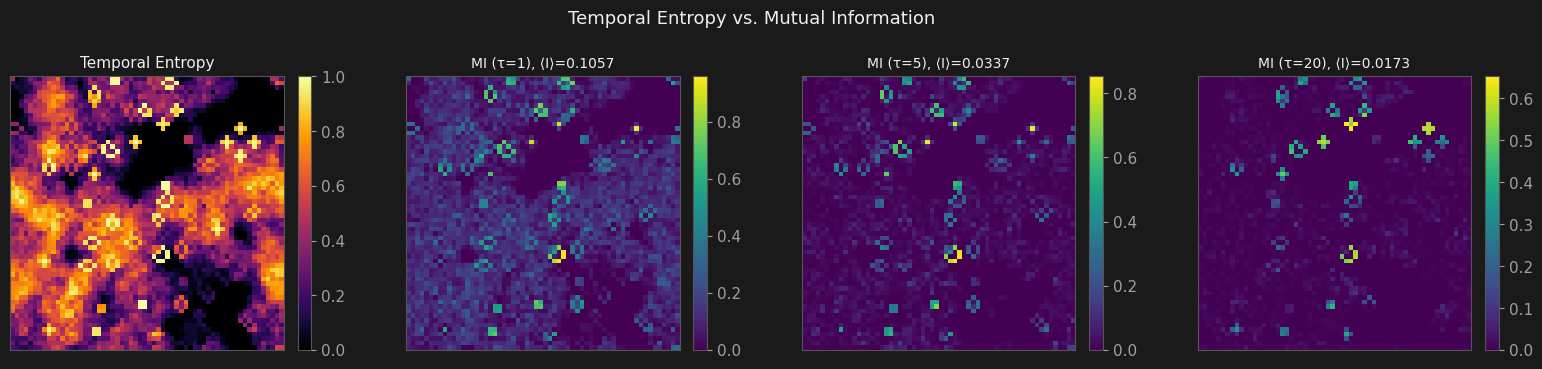

In [ ]:
# Mutual information maps
np.random.seed(42)
grid = random_soup(60, 60)
history = evolve(grid, 300)

# Use settled portion
settled_history = history[100:]

fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))

# Temporal entropy
H_map = temporal_entropy_map(settled_history)
im0 = axes[0].imshow(H_map, cmap='inferno', vmin=0, vmax=1)
axes[0].set_title('Temporal Entropy', fontsize=11)
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Mutual information at different lags
for i, tau in enumerate([1, 5, 20]):
    avg_mi, mi_map = mutual_information_temporal(settled_history, tau=tau)
    im = axes[i + 1].imshow(mi_map, cmap='viridis', vmin=0,
                            vmax=mi_map.max() if mi_map.max() > 0 else 1)
    axes[i + 1].set_title(f'MI (τ={tau}), ⟨I⟩={avg_mi:.4f}', fontsize=10)
    plt.colorbar(im, ax=axes[i + 1], fraction=0.046, pad=0.04)

for ax in axes:
    ax.set_xticks([]); ax.set_yticks([])

fig.suptitle('Temporal Entropy vs. Mutual Information', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---

## Part 6: Complete Entropy Analysis Pipeline

Bringing it all together: a single function that runs a full entropy analysis on any GoL configuration.

In [ ]:
def full_entropy_analysis(grid: np.ndarray, steps: int = 500,
                          k: int = 2, window: int = 50,
                          subsample: int = 5) -> dict:
    """
    Complete entropy analysis of a GoL evolution.

    Parameters
    ----------
    grid : initial configuration
    steps : number of generations to evolve
    k : block size for 2D block entropy
    window : number of final steps to use for temporal measures
    subsample : compute expensive measures every N steps

    Returns
    -------
    dict with history and all entropy measures
    """
    history = evolve(grid, steps)
    times = np.arange(0, steps + 1)
    sample_t = np.arange(0, steps + 1, subsample)

    results = {
        'history':          history,
        'times':            times,
        'sample_times':     sample_t,
        'density_rho':      np.array([h.mean() for h in history]),
        'density_H':        np.array([density_entropy(h) for h in history]),
        'population':       np.array([h.sum() for h in history]),
        'block_H':          np.array([block_entropy_2d(history[t], k)
                                      for t in sample_t]),
        'neigh_H_sum':      np.array([neighborhood_entropy(history[t], 'sum')
                                      for t in sample_t]),
        'neigh_H_full':     np.array([neighborhood_entropy(history[t], 'full')
                                      for t in sample_t]),
        'temporal_map':     temporal_entropy_map(history[-window:]),
    }
    return results

In [ ]:
def plot_entropy_analysis(results: dict, title: str = 'Entropy Analysis'):
    """Comprehensive 6-panel entropy visualization."""
    fig, axes = plt.subplots(2, 3, figsize=(16, 9))
    t = results['times']
    st = results['sample_times']

    # 1. Density entropy
    ax = axes[0, 0]
    ax.plot(t, results['density_H'], color=COLORS['accent'], lw=1.5)
    ax.axhline(y=results['density_H'][-1], color=COLORS['highlight'],
               ls='--', alpha=0.6, label=f'H_eq = {results["density_H"][-1]:.3f}')
    ax.set_title('Density Entropy'); ax.set_xlabel('t'); ax.set_ylabel('H [bits]')
    ax.legend(fontsize=8); ax.grid(alpha=0.3)

    # 2. Population density
    ax = axes[0, 1]
    ax.plot(t, results['density_rho'], color=COLORS['orange'], lw=1.5)
    ax.axhline(y=0.0287, color=COLORS['green'], ls=':', alpha=0.5,
               label='Flammenkamp')
    ax.set_title('Alive Density ρ(t)'); ax.set_xlabel('t'); ax.set_ylabel('ρ')
    ax.legend(fontsize=8); ax.grid(alpha=0.3)

    # 3. Block entropy
    ax = axes[0, 2]
    ax.plot(st, results['block_H'], color=COLORS['accent'], lw=1.5)
    ax.set_title('2D Block Entropy H_k'); ax.set_xlabel('t'); ax.set_ylabel('H [bits]')
    ax.grid(alpha=0.3)

    # 4. Neighborhood entropy
    ax = axes[1, 0]
    ax.plot(st, results['neigh_H_sum'], color=COLORS['accent'], lw=1.5,
            label='sum (10 classes)')
    ax.plot(st, results['neigh_H_full'], color=COLORS['highlight'], lw=1.5,
            label='full (512 classes)')
    ax.set_title('Neighborhood Entropy'); ax.set_xlabel('t'); ax.set_ylabel('H [bits]')
    ax.legend(fontsize=8); ax.grid(alpha=0.3)

    # 5. Temporal entropy map
    ax = axes[1, 1]
    im = ax.imshow(results['temporal_map'], cmap='inferno', vmin=0, vmax=1)
    ax.set_title('Temporal Entropy Map')
    ax.set_xticks([]); ax.set_yticks([])
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='H [bits]')

    # 6. Final state
    ax = axes[1, 2]
    ax.imshow(results['history'][-1], cmap='gray_r', interpolation='nearest')
    rho_f = results['density_rho'][-1]
    ax.set_title(f'Final State (ρ = {rho_f:.4f})')
    ax.set_xticks([]); ax.set_yticks([])

    fig.suptitle(title, fontsize=15, y=1.01)
    plt.tight_layout()
    plt.show()

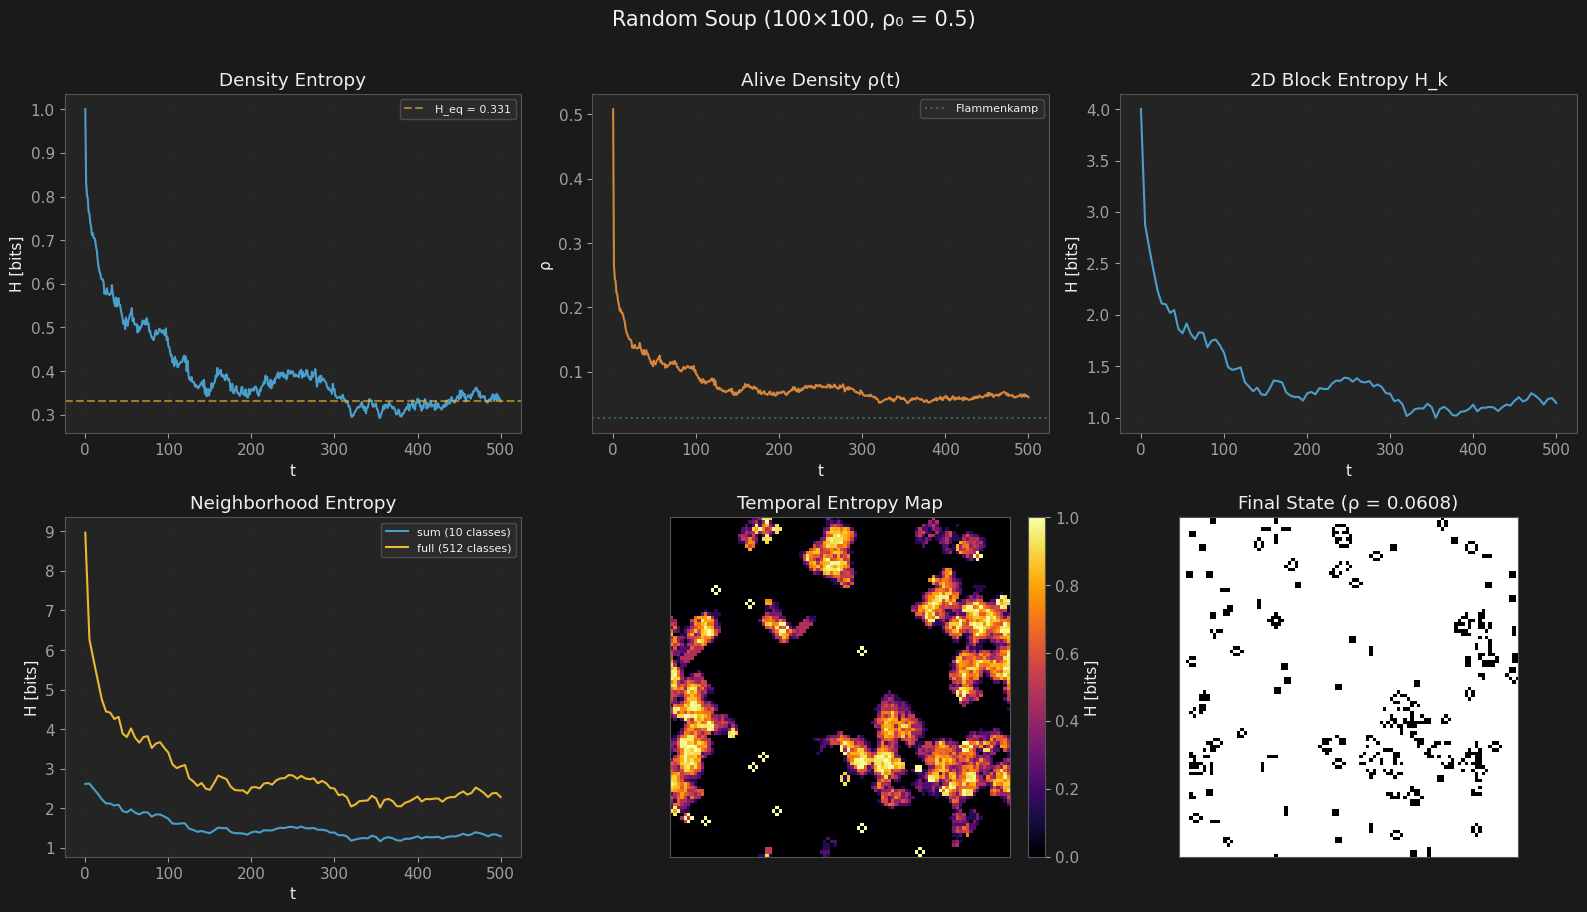


Summary:
  Initial density entropy: 0.9998 bits
  Final density entropy:   0.3306 bits
  Entropy drop:            0.6692 bits
  Final density:           0.0608
  Active cells (H>0):      2860


In [ ]:
# Full analysis: random soup
np.random.seed(42)
grid = random_soup(100, 100, density=0.5)
results = full_entropy_analysis(grid, steps=500, k=2)
plot_entropy_analysis(results, title='Random Soup (100×100, ρ₀ = 0.5)')

print(f'\nSummary:')
print(f'  Initial density entropy: {results["density_H"][0]:.4f} bits')
print(f'  Final density entropy:   {results["density_H"][-1]:.4f} bits')
print(f'  Entropy drop:            {results["density_H"][0] - results["density_H"][-1]:.4f} bits')
print(f'  Final density:           {results["density_rho"][-1]:.4f}')
print(f'  Active cells (H>0):      {(results["temporal_map"] > 0.01).sum()}')

---

## Part 7: Comparative Analysis

How do different initial conditions affect entropy trajectories?

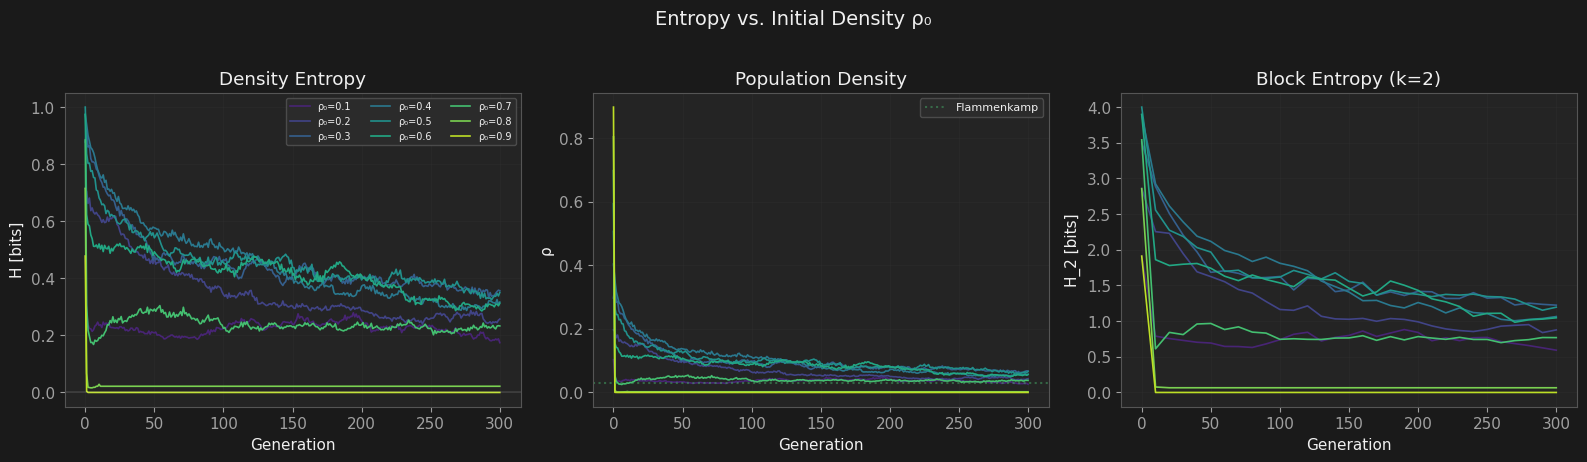

In [ ]:
# Compare entropy curves for different initial densities
np.random.seed(42)
densities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(densities)))

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

for rho0, col in zip(densities, colors):
    grid = random_soup(100, 100, density=rho0)
    hist = evolve(grid, 300)

    # Density entropy
    H_d = entropy_trajectory(hist)
    axes[0].plot(H_d, color=col, lw=1.2, label=f'ρ₀={rho0}')

    # Population density
    rho_t = density_trajectory(hist)
    axes[1].plot(rho_t, color=col, lw=1.2)

    # Block entropy (k=2)
    st = np.arange(0, 301, 10)
    H_b = [block_entropy_2d(hist[t], k=2) for t in st]
    axes[2].plot(st, H_b, color=col, lw=1.2)

axes[0].set_title('Density Entropy'); axes[0].set_ylabel('H [bits]')
axes[0].axhline(y=0, color='white', alpha=0.1)
axes[0].legend(fontsize=7, ncol=3, loc='upper right')

axes[1].set_title('Population Density'); axes[1].set_ylabel('ρ')
axes[1].axhline(y=0.0287, color=COLORS['green'], ls=':', alpha=0.5, label='Flammenkamp')
axes[1].legend(fontsize=8)

axes[2].set_title('Block Entropy (k=2)'); axes[2].set_ylabel('H_2 [bits]')

for ax in axes:
    ax.set_xlabel('Generation'); ax.grid(alpha=0.3)

fig.suptitle('Entropy vs. Initial Density ρ₀', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Observation

Regardless of the initial density $\rho_0$ (unless very close to 0 or 1), the system converges
to approximately the same equilibrium density $\rho \approx 0.03$. The entropy always decreases.
This is a striking example of **self-organization** and **universality** in GoL's dynamics.

---

## Exercises

### Exercise 1: Entropy vs. Initial Density (30 min)

Run GoL from random soups with $\rho_0 \in \{0.1, 0.2, \ldots, 0.9\}$.
Plot $H_{\text{density}}(t)$ for each.
- At what $\rho_0$ does entropy decrease most?
- Does the equilibrium density always converge to Flammenkamp's constant?
- Plot $\Delta H = H(0) - H(t_{\text{final}})$ vs. $\rho_0$.

### Exercise 2: Block Entropy Scaling (45 min)

For the settled configuration of a random 200×200 soup:
1. Compute $H_k$ for $k = 1, 2, 3, 4, 5$
2. Plot $H_k / k^2$ vs. $k$. Does it converge?
3. Compare with a purely random grid of the same density.
4. What does the difference tell you about spatial correlations?

### Exercise 3: Temporal Entropy Maps (45 min)

Evolve a Gosper glider gun for 300 steps.
1. Compute the temporal entropy map.
2. Identify the gun mechanism, glider tracks, and dead zones from the heatmap alone.
3. What is the average temporal entropy of the gun vs. a random soup?
4. Bonus: overlay the entropy map on the final state using transparency.

### Exercise ★: Entropy Across Life-like Rules (60+ min)

Implement a generalized life-like rule engine that accepts birth/survival strings
(e.g., B3/S23 for standard GoL, B36/S23 for HighLife, B2/S for Seeds).
Choose 5 rules and compare entropy trajectories from random soups.
- Which rules show anti-entropic behavior?
- Can you identify the 'edge of chaos' from entropy alone?
- How does the equilibrium density depend on the rule?

In [ ]:
# ─── EXERCISE 1: YOUR CODE HERE ───



In [ ]:
# ─── EXERCISE 2: YOUR CODE HERE ───



In [ ]:
# ─── EXERCISE 3: YOUR CODE HERE ───



In [ ]:
# ─── EXERCISE ★: YOUR CODE HERE ───
# Hint: generalized step function

def step_lifelike(grid: np.ndarray,
                  birth: set = {3},
                  survival: set = {2, 3}) -> np.ndarray:
    """One generation of a life-like rule B.../S..."""
    neighbors = convolve2d(grid, KERNEL, mode='same', boundary='wrap')
    born = np.isin(neighbors, list(birth)) & (grid == 0)
    survives = np.isin(neighbors, list(survival)) & (grid == 1)
    return (born | survives).astype(np.int8)

# Example: HighLife B36/S23
# grid = random_soup(100, 100)
# new_grid = step_lifelike(grid, birth={3, 6}, survival={2, 3})


---

## References

- Shannon, C.E. (1948). *A Mathematical Theory of Communication*. Bell System Technical Journal.
- Wolfram, S. (1984). Computation theory of cellular automata. *Comm. Math. Phys.* 96(1), 15–57.
- Cover, T.M. & Thomas, J.A. (2006). *Elements of Information Theory*. 2nd ed., Wiley.
- Pan, Z. (2010). Emergence from symmetry: A new type of cellular automata. arXiv:1003.3394.
- Ruivo et al. (2023). Thermodynamics in Stochastic Conway's GoL. *MDPI Dynamics* 8(2), 47.
- Contreras-Reyes, J.E. (2021). Lerch distribution based on MaxNSEntr: Application to GoL. *Chaos, Solitons & Fractals*.
- Sherrill et al. (2024). Conway's GoL as an Analogue to a Habitable World. arXiv:2410.22389.
- Brown, N. et al. (2023). Conway's Game of Life is Omniperiodic. arXiv:2312.02799.